# Train Model

## Imports

In [1]:
use_colab = True

if use_colab:
  %pip install split-folders
  from google.colab import drive
  drive.mount('/content/data/', force_remount=True)
  data_file = './data/MyDrive/train.zip'
else:
  data_file = './data/train.zip'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/data/


In [2]:
import os
import shutil
import splitfolders
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from dogs_vs_cats_model import DogsVsCats

## Detect GPU if Available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Prepare Data

In [4]:
data_zip = os.path.abspath(data_file)
temp_dir = os.path.abspath('./train')
input_dir = os.path.abspath('./input')
train_dir = os.path.abspath('./input/train')
test_dir = os.path.abspath('./input/test')
val_dir = os.path.abspath('./input/val')

def unzip_data():
    if os.path.exists(input_dir):
        print('Input directory already exists.')
        return
    
    if not os.path.exists(data_zip):
        print('Data not found.')
        return

    with zipfile.ZipFile(data_zip, 'r') as z:
        z.extractall()

    dog_dir = os.path.join(input_dir, 'dog')
    cat_dir = os.path.join(input_dir, 'cat')
    os.mkdir(input_dir)
    os.mkdir(dog_dir)
    os.mkdir(cat_dir)

    for file_name in os.listdir(temp_dir):
        file_path = os.path.join(temp_dir, file_name)
        animal = file_name.split('.')[0]
        new_file_path = os.path.join(input_dir, animal, file_name)
        try:
            shutil.move(file_path, new_file_path)
        except FileNotFoundError:
            print(f'Could not find image: {file_name}')

    splitfolders.ratio(input_dir, input_dir, move=True)
    os.rmdir(temp_dir)
    os.rmdir(dog_dir)
    os.rmdir(cat_dir)

In [5]:
unzip_data()

Input directory already exists.


## Transforms, Datasets, and Dataloaders

In [6]:
mean = torch.tensor([0.4632, 0.4293, 0.3929])
std = torch.tensor([0.2646, 0.2550, 0.2536])
batch_size = 256
num_workers = 2
image_size = 128

train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.GaussianBlur(5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

print(f'Batch size: {batch_size}')
print(f'Number of training images: {len(train_dataset)} ({len(train_dataloader)} batches)')
print(f'Number of testing images: {len(test_dataset)} ({len(test_dataloader)} batches)')
print(f'Number of validation images: {len(val_dataset)} ({len(val_dataloader)} batches)')

Batch size: 256
Number of training images: 20000 (79 batches)
Number of testing images: 2500 (10 batches)
Number of validation images: 2500 (10 batches)


In [7]:
# Used to get the mean and std for the normalize transform above
def get_mean_and_std(dataloader):
    c_sum, c_sum_sq, num_batches = 0, 0, 0

    for data, _ in dataloader:
        c_sum += torch.mean(data, dim=[0,2,3])
        c_sum_sq += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = c_sum / num_batches
    std = (c_sum_sq / num_batches - mean ** 2) ** 0.5

    return mean, std

# print(get_mean_and_std(train_dataloader))

## Display a Training Image

cat


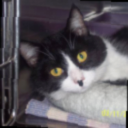

In [8]:
images, labels = next(iter(train_dataloader))
to_image = transforms.ToPILImage()
un_normalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

print('dog' if labels[0].item() else 'cat')
display(to_image(un_normalize(images[0])))

## Hyperparameters

In [13]:
model = DogsVsCats(image_size)
model = model.to(device)

epochs = 20
lr = 0.004
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Training

In [14]:
train_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    curr_train_acc = []

    for data, target in train_dataloader:
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        prediction = torch.argmax(output, dim=1)
        curr_train_acc.extend((prediction == target).detach().cpu().numpy())

    curr_train_acc = np.mean(curr_train_acc)
    train_acc.append(curr_train_acc)

    model.eval()
    with torch.no_grad():
        curr_val_acc = []

        for data, target in val_dataloader:
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            output = model(data)
            prediction = torch.argmax(output, dim=1)
            curr_val_acc.extend((prediction == target).detach().cpu().numpy())

    curr_val_acc = np.mean(curr_val_acc)
    val_acc.append(curr_val_acc)

    print(f'Epoch {epoch}/{epochs} (Train accuracy: {curr_train_acc * 100:.2f}%, \
        Validation accuracy: {curr_val_acc * 100:.2f}%')


Epoch 0/20 (Train accuracy: 55.94%,         Validation accuracy: 61.24%
Epoch 1/20 (Train accuracy: 64.42%,         Validation accuracy: 67.80%
Epoch 2/20 (Train accuracy: 68.10%,         Validation accuracy: 69.16%
Epoch 3/20 (Train accuracy: 70.18%,         Validation accuracy: 70.32%
Epoch 4/20 (Train accuracy: 72.17%,         Validation accuracy: 71.04%
Epoch 5/20 (Train accuracy: 74.08%,         Validation accuracy: 71.40%
Epoch 6/20 (Train accuracy: 75.39%,         Validation accuracy: 74.84%
Epoch 7/20 (Train accuracy: 75.56%,         Validation accuracy: 75.92%
Epoch 8/20 (Train accuracy: 77.69%,         Validation accuracy: 77.52%
Epoch 9/20 (Train accuracy: 77.83%,         Validation accuracy: 76.00%
Epoch 10/20 (Train accuracy: 78.38%,         Validation accuracy: 77.16%
Epoch 11/20 (Train accuracy: 78.94%,         Validation accuracy: 79.72%
Epoch 12/20 (Train accuracy: 80.19%,         Validation accuracy: 79.76%
Epoch 13/20 (Train accuracy: 80.33%,         Validation accur

## Plot Accuracy

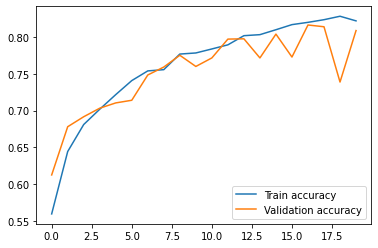

In [15]:
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
leg = plt.legend(loc='lower right')
plt.show()

## Run Model on Test Set

In [16]:
model.eval()
with torch.no_grad():
    test_acc = []

    for data, target in test_dataloader:
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        output = model(data)
        prediction = torch.argmax(output, dim=1)
        test_acc.extend((prediction == target).detach().cpu().numpy())

test_acc = np.mean(test_acc)
print(f'Testing accuracy: {test_acc * 100:.2f}%')

Testing accuracy: 82.24%


## Save the Model

In [17]:
torch.save(model.state_dict(), './model.pt')